In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

/Users/steve/steve/neural-language-models/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# read data

In [4]:
words = open('../data/names.txt', 'r').read().splitlines()

In [5]:
len(words)

32033

In [6]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
chars = sorted(list(set(''.join(words))))

# util 

In [8]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [9]:
stoi = {s: i for i, s in itos.items()}

# build N

In [10]:
len(itos)

27

In [11]:
N = torch.zeros(len(itos), len(itos))

In [12]:
for w in words[:]:
    w2 = '.' + w + '.'
    for ch1, ch2 in zip(w2, w2[1:]):
        if ch1 != '.' and ch1 != 'a':
            continue
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [13]:
P = N / N.sum(1, keepdim=True)

In [14]:
P[0].sum(), P[:,0].sum()

(tensor(1.), tensor(nan))

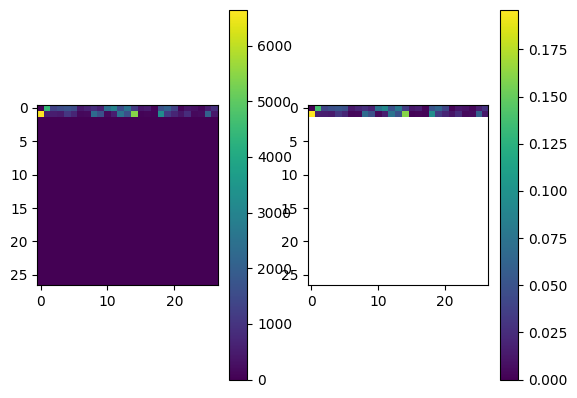

In [15]:
plt.subplot(121)
plt.imshow(N)
plt.colorbar()
plt.subplot(122)
plt.imshow(P)
plt.colorbar()
plt.show()

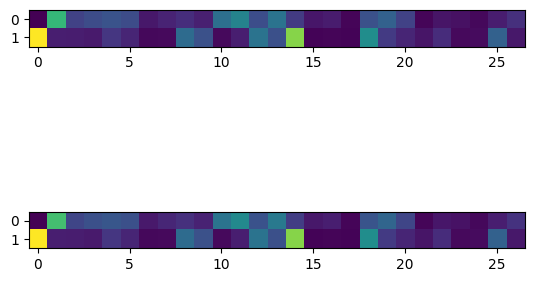

In [16]:
plt.subplot(211)
plt.imshow(N[0:2,:])
plt.subplot(212)
plt.imshow(P[0:2,:])
plt.show()

# compute loss

In [17]:
nll = 0
n = 0
for w in words[:]:
    w2 = '.' + w + '.'
    for ch1, ch2 in zip(w2, w2[1:]):
        if ch1 != '.' and ch1 != 'a':
            continue
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        nll += -P[ix1, ix2].log().item()
        n += 1
nll/n

2.8097695527411934

# train a bigram nn

## prepare data

In [18]:
xs, ys = [], []
for w in words[:]:
    w2 = '.' + w + '.'
    for ch1, ch2 in zip(w2, w2[1:]):
        if ch1 != '.' and ch1 != 'a':
            continue
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

In [19]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [20]:
xs, ys

(tensor([0, 1, 0,  ..., 0, 0, 0]), tensor([ 5,  0, 15,  ..., 26, 26, 26]))

In [21]:
xs.shape, ys.shape

(torch.Size([65918]), torch.Size([65918]))

## build a simple nn

In [22]:
w = torch.randn(len(itos), len(itos))

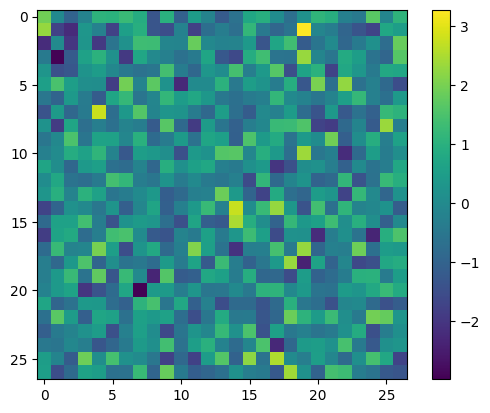

In [23]:
plt.imshow(w.data);
plt.colorbar()
plt.show()

In [24]:
losses = []
# w = torch.randn(len(itos), len(itos), requires_grad=True)
w = torch.zeros((len(itos), len(itos)), requires_grad=True)

for i in tqdm(range(500)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()

    # update
    w.data += -10.0 * w.grad

100%|████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.94it/s]


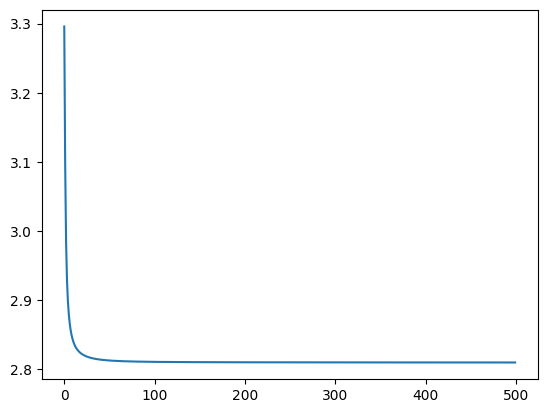

In [25]:
plt.plot(losses);

In [26]:
losses[-5:]

[2.8099570274353027,
 2.8099567890167236,
 2.8099563121795654,
 2.8099558353424072,
 2.809955596923828]

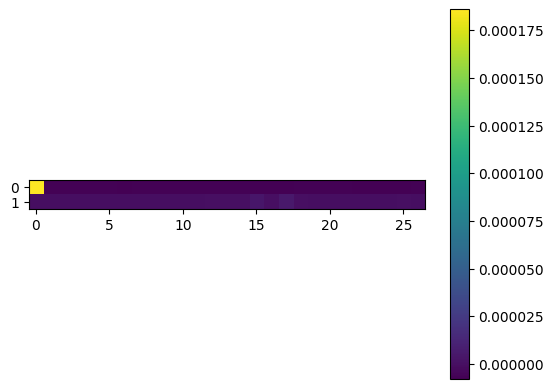

In [27]:
plt.imshow(w.grad[0:2,])
plt.colorbar()
plt.show()

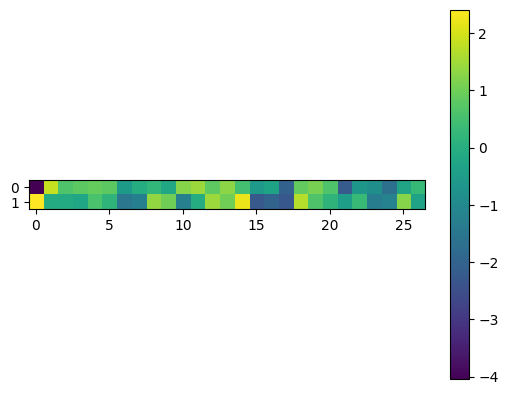

In [28]:
plt.imshow(w.data[0:2])
plt.colorbar()
plt.show()

In [29]:
w[0].exp() / w[0].exp().sum()

tensor([0.0004, 0.1377, 0.0408, 0.0481, 0.0527, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0641, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290],
       grad_fn=<DivBackward0>)

In [30]:
P[0]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [31]:
w[1].exp() / w[1].exp().sum()

tensor([0.1960, 0.0164, 0.0160, 0.0139, 0.0308, 0.0204, 0.0040, 0.0050, 0.0688,
        0.0487, 0.0052, 0.0168, 0.0746, 0.0482, 0.1605, 0.0019, 0.0024, 0.0018,
        0.0963, 0.0330, 0.0203, 0.0112, 0.0246, 0.0048, 0.0054, 0.0605, 0.0128],
       grad_fn=<DivBackward0>)

In [32]:
P[1]

tensor([0.1960, 0.0164, 0.0160, 0.0139, 0.0308, 0.0204, 0.0040, 0.0050, 0.0688,
        0.0487, 0.0052, 0.0168, 0.0746, 0.0482, 0.1605, 0.0019, 0.0024, 0.0018,
        0.0963, 0.0330, 0.0203, 0.0112, 0.0246, 0.0048, 0.0054, 0.0605, 0.0128])

## Does the original P minimize the loss of the nn?

In [33]:
w = torch.zeros_like(P, requires_grad=True)

In [34]:
w.data[0] = P[0]

In [35]:
w.data[1] = P[1]

In [36]:
losses = []
# w = P.clone().detach().requires_grad_(True)

for i in tqdm(range(100)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()
    break
    
    # update
    w.data += -50.0 * w.grad

  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]


In [37]:
w.grad[0:2,]

tensor([[ 0.0173, -0.0470, -0.0018, -0.0052, -0.0074, -0.0050,  0.0112,  0.0076,
          0.0046,  0.0087, -0.0180, -0.0259, -0.0056, -0.0197,  0.0006,  0.0116,
          0.0098,  0.0160, -0.0066, -0.0127, -0.0018,  0.0162,  0.0118,  0.0128,
          0.0154,  0.0095,  0.0038],
        [-0.0784,  0.0102,  0.0104,  0.0115,  0.0031,  0.0082,  0.0164,  0.0159,
         -0.0157, -0.0058,  0.0158,  0.0100, -0.0186, -0.0056, -0.0610,  0.0174,
          0.0171,  0.0174, -0.0293,  0.0020,  0.0083,  0.0128,  0.0061,  0.0160,
          0.0157, -0.0116,  0.0120]])

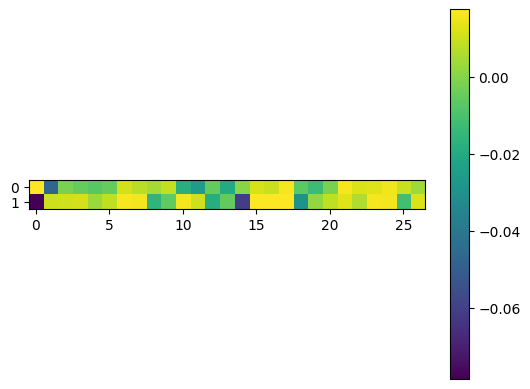

In [38]:
plt.imshow(w.grad[0:2])
plt.colorbar()
plt.show()

## What kind of loss does P minimize?

In [39]:
losses = []
w = torch.zeros((len(itos), len(itos)), requires_grad=True)

for i in tqdm(range(100)):
    # forward
    xenc = F.one_hot(xs, num_classes=len(itos)).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    losses.append(loss.item())

    # backword
    w.grad = None
    loss.backward()
    break
    
    # update
    w.data += -50.0 * w.grad

  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]
